# Battle of the Neighborhoods
by **Morteza Ghorbani Kari**

### Part 1: Scrap the web & Locate the districts

In [321]:
# Importing libraries
import time
from math import sin, cos, sqrt, atan2, radians
import pandas as pd
import numpy as np

import requests
from bs4 import BeautifulSoup

from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut, GeocoderUnavailable
from shapely.geometry import Point

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

import folium

#### Function for Geolocation

In [3]:
def latLng(name):
    """
    input: address
    output: (latitude, longitude)
    """
    address = name
    geolocator = Nominatim(user_agent="Istanbul")
    
    # Trying to get past repeated GeocoderTimedOut and GeocoderUnavailable errors
    try:   
        location = geolocator.geocode(address)
        
    except (GeocoderTimedOut, GeocoderUnavailable):
        time.sleep(1) # Giving it some time
        location = latLng(name)
        
    print("#", end="")
    
    return location

#### Function for distance

In [4]:
def distance(point1, point2):
    """
    input: two shapely Point objects
    output: distance between the points (in kilometers)
    """
    
    # approximate radius of earth in km
    R = 6373.0
    
    lat1 = radians(point1.x)
    lon1 = radians(point1.y)
    lat2 = radians(point2.x)
    lon2 = radians(point2.y)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c

    return distance

#### Scraping webpage for district names

In [4]:
# Reading the whole webpage content
url = 'https://en.wikipedia.org/wiki/List_of_districts_of_Istanbul'
page = requests.get(url)
raw_data = BeautifulSoup(page.text)

In [5]:
# Extracting the needed data from the contents

raw_table = raw_data.select('td:nth-child(1)')
istanbul_districts = pd.DataFrame(columns=["District", "Latitude", "Longitude"], index=range(39))

ind = 0
for line in raw_table:
    if line.string == " ":
        continue
        
    elif line.a in line:
        istanbul_districts.loc[ind,"District"] = line.a.string.strip()
        ind += 1

istanbul_districts = istanbul_districts.astype({"Latitude": 'float', "Longitude": 'float'})

In [6]:
for index, row in istanbul_districts.iterrows():
    location = latLng(row[0]+', Istanbul')
    istanbul_districts.loc[index, "Latitude"] = location.latitude
    istanbul_districts.loc[index, "Longitude"] = location.longitude
print("\n", end="")
print("Geolocating Districts is done!")

istanbul_districts.head()

########################################
Geolocating Districts is done!


,District,Latitude,Longitude
0,Adalar,40.876259,29.091027
1,Arnavutköy,41.184182,28.740729
2,Ataşehir,40.984749,29.106720
3,Avcılar,40.980135,28.717547
4,Bağcılar,41.033899,28.857898


#### merging with Sale Price column

In [12]:
try:
    istanbul_districts.drop('Sale Price', axis=1, inplace=True)
except:
    pass

sale_price = pd.read_csv("Istanbul_For_Sale_House_12_Month_Average_m2_Prices.csv")
istanbul_districts = pd.merge(istanbul_districts,sale_price)
istanbul_districts.head()

,District,Latitude,Longitude,Sale Price
0,Adalar,40.876259,29.091027,5568
1,Arnavutköy,41.184182,28.740729,2265
2,Ataşehir,40.984749,29.106720,5512
3,Avcılar,40.980135,28.717547,2454
4,Bağcılar,41.033899,28.857898,3264


### Calculating the distance to the closest district
#### and setting the search radius for each district

In [7]:

data_points = dict()

for index, row in istanbul_districts.iterrows():
    name = row[0]
    point = Point(row[1], row[2]) 
    data_points[name] = point

In [8]:
distances = pd.DataFrame(columns=data_points.keys(), index=data_points.keys(), dtype=float)

for dist1 in data_points.keys():
    for dist2 in data_points.keys():
        distances.loc[dist1, dist2] = distance(data_points[dist1], data_points[dist2])
        
# Replacing 0s so they don't mess up the minimum distance calculation
distances[distances == 0] = None

min_dist = distances.min().reset_index()
min_dist.columns = ["District", "Distance"]

print(f'The minimum distance between districts is {distances.min().min():.3f} KMs.\nWe will use this distance for our venue search.')

The minimum distance between districts is 1.513 KMs.
We will use this distance for our venue search.


In [12]:
# run if you are not online
# istanbul_districts = pd.read_csv('Istanbul_Districts.csv')

In [9]:
try:
    istanbul_districts.drop('Distance', axis=1, inplace=True)
except:
    pass

istanbul_districts = pd.merge(istanbul_districts, min_dist)

# Only using half the Distance to closest District AND using meters instead of KMs
istanbul_districts['Distance'] = istanbul_districts['Distance']/2*1000

istanbul_districts.head()

,District,Latitude,Longitude,Sale Price,Distance
0,Adalar,40.876259,29.091027,5568,3655.064197
1,Arnavutköy,41.184182,28.740729,2265,6181.584805
2,Ataşehir,40.984749,29.106720,5512,1409.093554
3,Avcılar,40.980135,28.717547,2454,2884.041216
4,Bağcılar,41.033899,28.857898,3264,870.697134


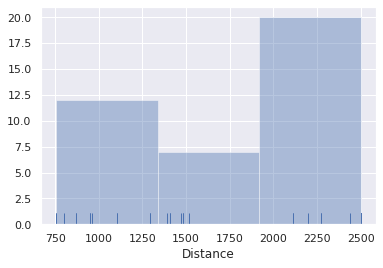

In [11]:
# Capping the radius at 2500 meters (for large districts)
bigger_2500 = istanbul_districts['Distance'] > 2500
istanbul_districts.loc[bigger_2500, 'Distance'] = 2500

sns.distplot(istanbul_districts["Distance"], kde=False, rug=True)

In [68]:
istanbul_districts.to_csv("Istanbul_Districts.csv", index=False)

In [322]:
ist_lat = 41.0082
ist_lng = 28.9784

map_istanbul = folium.Map(location=[ist_lat, ist_lng], zoom_start=9)

for lat, lng, district, dist in zip(istanbul_districts['Latitude'], istanbul_districts['Longitude'],
                                                 istanbul_districts['District'], istanbul_districts['Distance']):
    label = f'{district}'
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
                  [lat, lng],
                  radius=dist,
                  popup=label,
                  color='#ff0000',
                  fill=True,
                  fill_color='#ffff00',
                  fill_opacity=0.4,
                  parse_html=False,
).add_to(map_istanbul)

map_istanbul

### Part 2: Explore venues

In [31]:
CLIENT_ID = 'AECEZ05OKNUM4DDQZPMRZ3FNDFXEWNFMHKAGCOUAYSCR4CJ1' # your Foursquare ID
CLIENT_SECRET = 'M3EOELPIXED54OA0QFAX0MTJNH3KLW5V1ZBYVOUE0OW4DEYD' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

LIMIT = 100

Your credentails:
CLIENT_ID: AECEZ05OKNUM4DDQZPMRZ3FNDFXEWNFMHKAGCOUAYSCR4CJ1
CLIENT_SECRET:M3EOELPIXED54OA0QFAX0MTJNH3KLW5V1ZBYVOUE0OW4DEYD


#### Function for exploring venues

In [32]:
def getNearbyVenues(names, latitudes, longitudes, radius):
    
    venues_list=[]
    for name, lat, lng, rad in zip(names, latitudes, longitudes, radius):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            rad, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Exploring districts

In [34]:
istanbul_venues = getNearbyVenues(names=istanbul_districts['District'],
                                  latitudes=istanbul_districts['Latitude'],
                                  longitudes=istanbul_districts['Longitude'],
                                  radius=istanbul_districts['Distance']
                                  )

Adalar
Arnavutköy
Ataşehir
Avcılar
Bağcılar
Bahçelievler
Bakırköy
Başakşehir
Bayrampaşa
Beşiktaş
Beykoz
Beylikdüzü
Beyoğlu
Büyükçekmece
Çatalca
Çekmeköy
Esenler
Esenyurt
Eyüp
Fatih
Gaziosmanpaşa
Güngören
Kadıköy
Kağıthane
Kartal
Küçükçekmece
Maltepe
Pendik
Sancaktepe
Sarıyer
Silivri
Sultanbeyli
Sultangazi
Şile
Şişli
Tuzla
Ümraniye
Üsküdar
Zeytinburnu


In [35]:
istanbul_venues.to_csv('Istanbul_Venues.csv', index=False)
istanbul_venues.shape

(3771, 7)

In [36]:
istanbul_venues.head(10)

,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adalar,40.876259,29.091027,İnönü Evi Müzesi,40.878251,29.093647,History Museum
1,Adalar,40.876259,29.091027,L'isola Guesthouse,40.877038,29.096136,Bed & Breakfast
2,Adalar,40.876259,29.091027,Merit Halki Palace Hotel,40.878802,29.090974,Hotel
3,Adalar,40.876259,29.091027,Heybeliada Şafak Askeri Gazino,40.873609,29.099478,Restaurant
4,Adalar,40.876259,29.091027,Heybeliada Su Sporları Kulübü,40.882365,29.089167,Pool
5,Adalar,40.876259,29.091027,Heybeliada Çam Limanı,40.870158,29.084727,Harbor / Marina
6,Adalar,40.876259,29.091027,Farkli Bi' Yer,40.876581,29.100965,Café
7,Adalar,40.876259,29.091027,Luz Café,40.877528,29.097877,Café
8,Adalar,40.876259,29.091027,Erguvan Evyemekleri,40.876864,29.100745,Turkish Restaurant
9,Adalar,40.876259,29.091027,Heybeliada Deniz Lisesi Kolaylık Tesisleri,40.870648,29.097261,Restaurant


In [14]:
from folium.plugins import FastMarkerCluster

ist_lat = 41.0082
ist_lng = 28.9784

map_district = folium.Map(location=[ist_lat, ist_lng], zoom_start=9)
map_district.add_child(FastMarkerCluster(istanbul_venues[['Venue Latitude', 'Venue Longitude', 'District Latitude']].values.tolist()))

In [15]:
print('There are {} uniques categories.'.format(len(istanbul_venues['Venue Category'].unique())))

There are 306 uniques categories.


In [36]:
istanbul_onehot = pd.get_dummies(istanbul_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
istanbul_onehot['District'] = istanbul_venues['District'] 

# move neighborhood column to the first column
fixed_columns = [istanbul_onehot.columns[-1]] + list(istanbul_onehot.columns[:-1])
istanbul_onehot = istanbul_onehot[fixed_columns]

istanbul_onehot.head()

,District,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,...,Watch Shop,Water Park,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Çöp Şiş Place
0,Adalar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Adalar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Adalar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Adalar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Adalar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
istanbul_onehot.shape

(3771, 307)

In [38]:
istanbul_grouped = istanbul_onehot.groupby('District').mean().reset_index()
istanbul_grouped.head(20)

,District,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,...,Watch Shop,Water Park,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Çöp Şiş Place
0,Adalar,0.00,0.00,0.0,0.0,0.00,0.000000,0.000000,0.0,0.00,...,0.00,0.00,0.01,0.000000,0.00,0.00,0.00,0.000000,0.00,0.00
1,Arnavutköy,0.00,0.00,0.0,0.0,0.00,0.000000,0.053571,0.0,0.00,...,0.00,0.00,0.00,0.017857,0.00,0.00,0.00,0.000000,0.00,0.00
2,Ataşehir,0.00,0.00,0.0,0.0,0.00,0.000000,0.000000,0.0,0.00,...,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.000000,0.00,0.01
3,Avcılar,0.00,0.00,0.0,0.0,0.00,0.000000,0.020000,0.0,0.00,...,0.00,0.00,0.00,0.000000,0.00,0.00,0.02,0.000000,0.00,0.00
4,Bahçelievler,0.00,0.00,0.0,0.0,0.00,0.000000,0.000000,0.0,0.00,...,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.000000,0.00,0.00
5,Bakırköy,0.00,0.00,0.0,0.0,0.00,0.000000,0.010000,0.0,0.00,...,0.01,0.00,0.00,0.000000,0.00,0.00,0.00,0.000000,0.03,0.00
6,Bayrampaşa,0.00,0.00,0.0,0.0,0.00,0.010309,0.020619,0.0,0.00,...,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.010309,0.00,0.00
7,Bağcılar,0.01,0.00,0.0,0.0,0.00,0.000000,0.000000,0.0,0.00,...,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.000000,0.00,0.00
8,Başakşehir,0.00,0.00,0.0,0.0,0.00,0.000000,0.010000,0.0,0.00,...,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.000000,0.00,0.01
9,Beykoz,0.00,0.00,0.0,0.0,0.00,0.000000,0.020000,0.0,0.00,...,0.00,0.00,0.01,0.000000,0.00,0.01,0.00,0.000000,0.00,0.00


In [39]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [40]:
#istanbul_grouped.drop('Sale Price', axis=1, inplace=True)
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['District'] = istanbul_grouped['District']

for ind in np.arange(istanbul_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(istanbul_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adalar,Seafood Restaurant,Beach,Café,Restaurant,Turkish Restaurant,Other Great Outdoors,Campground,Fast Food Restaurant,Pool,Ice Cream Shop
1,Arnavutköy,Café,Restaurant,Turkish Restaurant,Gym,Kofte Place,Arcade,Campground,Fish & Chips Shop,Dessert Shop,Bakery
2,Ataşehir,Restaurant,Steakhouse,Hotel,Café,Gym / Fitness Center,Kebab Restaurant,Doner Restaurant,Coffee Shop,Basketball Stadium,Basketball Court
3,Avcılar,Café,Dessert Shop,Coffee Shop,Gym / Fitness Center,Restaurant,Gym,Plaza,Bar,Pizza Place,Pub
4,Bahçelievler,Café,Dessert Shop,Turkish Restaurant,Gym,Restaurant,Ice Cream Shop,Hookah Bar,Breakfast Spot,Fast Food Restaurant,Nail Salon


### Scaling Prices and adding them to the data

In [41]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(istanbul_districts['Sale Price'].values.reshape(-1, 1))

In [42]:
istanbul_grouped['Price'] = scaled_prices
istanbul_grouped.head()

,District,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,...,Water Park,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Çöp Şiş Place,Price
0,Adalar,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.01,0.000000,0.0,0.0,0.00,0.0,0.0,0.00,0.344032
1,Arnavutköy,0.0,0.0,0.0,0.0,0.0,0.0,0.053571,0.0,0.0,...,0.0,0.00,0.017857,0.0,0.0,0.00,0.0,0.0,0.00,0.016840
2,Ataşehir,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.00,0.000000,0.0,0.0,0.00,0.0,0.0,0.01,0.338484
3,Avcılar,0.0,0.0,0.0,0.0,0.0,0.0,0.020000,0.0,0.0,...,0.0,0.00,0.000000,0.0,0.0,0.02,0.0,0.0,0.00,0.035562
4,Bahçelievler,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.00,0.000000,0.0,0.0,0.00,0.0,0.0,0.00,0.115800


### Executing Elbow Method

In [43]:
#!conda install -c districtdatalabs yellowbrick --y

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

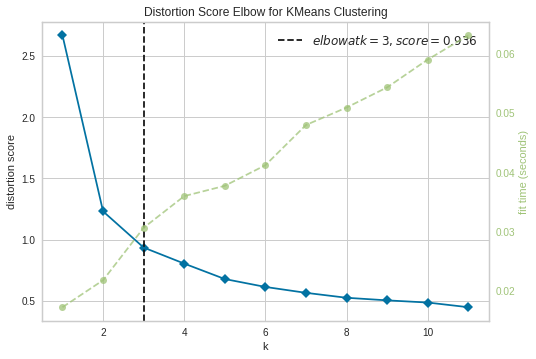

In [44]:
# set number of clusters
istanbul_grouped_clustering = istanbul_grouped.drop('District', 1)

# run k-means clustering
kmeans = KMeans().fit(istanbul_grouped_clustering)

visualizer = KElbowVisualizer(kmeans, k=(1, 12), metric='distortion')

# Fit the data to the visualizer
visualizer.fit(istanbul_grouped_clustering)        
visualizer.show() 

# check cluster labels generated for each row in the dataframe
#kmeans.labels_[0:10] 

In [33]:
istanbul_grouped_clustering

,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,...,Water Park,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Çöp Şiş Place,Price
0,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,0.00,0.00,...,0.00,0.01,0.000000,0.00,0.00,0.00,0.000000,0.00,0.00,0.344032
1,0.00,0.00,0.00,0.00,0.00,0.000000,0.053571,0.00,0.00,0.00,...,0.00,0.00,0.017857,0.00,0.00,0.00,0.000000,0.00,0.00,0.016840
2,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,0.00,0.01,...,0.00,0.00,0.000000,0.00,0.00,0.00,0.000000,0.00,0.01,0.338484
3,0.00,0.00,0.00,0.00,0.00,0.000000,0.020000,0.00,0.00,0.02,...,0.00,0.00,0.000000,0.00,0.00,0.02,0.000000,0.00,0.00,0.035562
4,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,0.00,0.00,...,0.00,0.00,0.000000,0.00,0.00,0.00,0.000000,0.00,0.00,0.115800
5,0.00,0.00,0.00,0.00,0.00,0.000000,0.010000,0.00,0.00,0.01,...,0.00,0.00,0.000000,0.00,0.00,0.00,0.000000,0.03,0.00,0.094502
6,0.00,0.00,0.00,0.00,0.00,0.010309,0.020619,0.00,0.00,0.00,...,0.00,0.00,0.000000,0.00,0.00,0.00,0.010309,0.00,0.00,0.703814
7,0.01,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,0.00,0.01,...,0.00,0.00,0.000000,0.00,0.00,0.00,0.000000,0.00,0.00,0.110847
8,0.00,0.00,0.00,0.00,0.00,0.000000,0.010000,0.00,0.00,0.00,...,0.00,0.00,0.000000,0.00,0.00,0.00,0.000000,0.00,0.01,0.127192
9,0.00,0.00,0.00,0.00,0.00,0.000000,0.020000,0.00,0.00,0.00,...,0.00,0.01,0.000000,0.00,0.01,0.00,0.000000,0.00,0.00,1.000000


### Clustering with K-mean

In [29]:
kclusters = 3
KNN_clustering = KMeans(n_clusters=kclusters, random_state=42)
KNN_clustering.fit(istanbul_grouped_clustering)
KNN_clustering.labels_[0:10] 

array([2, 1, 2, 1, 1, 1, 0, 1, 1, 0], dtype=int32)

## Results

In [30]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', KNN_clustering.labels_)

istanbul_merged = istanbul_districts

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
istanbul_merged = istanbul_merged.join(neighborhoods_venues_sorted.set_index('District'), on='District')

istanbul_merged.head() # check the last columns!

,District,Latitude,Longitude,Sale Price,Distance,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adalar,40.876259,29.091027,5568,2500.000000,2,Seafood Restaurant,Beach,Café,Restaurant,Turkish Restaurant,Other Great Outdoors,Campground,Fast Food Restaurant,Pool,Ice Cream Shop
1,Arnavutköy,41.184182,28.740729,2265,2500.000000,1,Café,Restaurant,Turkish Restaurant,Gym,Kofte Place,Arcade,Campground,Fish & Chips Shop,Dessert Shop,Bakery
2,Ataşehir,40.984749,29.106720,5512,1409.093554,2,Restaurant,Steakhouse,Hotel,Café,Gym / Fitness Center,Kebab Restaurant,Doner Restaurant,Coffee Shop,Basketball Stadium,Basketball Court
3,Avcılar,40.980135,28.717547,2454,2500.000000,1,Café,Dessert Shop,Coffee Shop,Gym / Fitness Center,Restaurant,Gym,Plaza,Bar,Pizza Place,Pub
4,Bağcılar,41.033899,28.857898,3264,870.697134,1,Café,Gym,Coffee Shop,Turkish Restaurant,Hookah Bar,Dessert Shop,Gym / Fitness Center,Fast Food Restaurant,Shopping Mall,Burger Joint


In [195]:
grouped = istanbul_merged[['District', 'Cluster Labels', '1st Most Common Venue', \
                           '2nd Most Common Venue', '3rd Most Common Venue',
                          ]]

grouped.loc[:, 'Top Venues'] = grouped.apply(lambda x: ", ".join(x.iloc[2:5]), axis=1)
grouped = grouped.drop(['1st Most Common Venue', '2nd Most Common Venue', '3rd Most Common Venue'], axis=1)

In [196]:
istanbul_results = pd.merge(istanbul_districts, grouped)
istanbul_results.head()

,District,Latitude,Longitude,Sale Price,Distance,Cluster Labels,Top Venues
0,Adalar,40.876259,29.091027,5568,2500.000000,2,"Seafood Restaurant, Beach, Café"
1,Arnavutköy,41.184182,28.740729,2265,2500.000000,1,"Café, Restaurant, Turkish Restaurant"
2,Ataşehir,40.984749,29.106720,5512,1409.093554,2,"Restaurant, Steakhouse, Hotel"
3,Avcılar,40.980135,28.717547,2454,2500.000000,1,"Café, Dessert Shop, Coffee Shop"
4,Bağcılar,41.033899,28.857898,3264,870.697134,1,"Café, Gym, Coffee Shop"


### Mean Appearance of venue categories in each cluster

In [295]:
def mix(group):
    return ', '.join(group['Top Venues'].tolist())
top_venues = grouped.groupby('Cluster Labels').apply(mix)

c0dist = grouped.groupby('Cluster Labels').get_group(0).shape[0]
clr0 = pd.Series(top_venues[0].split(', '), name='Cluster 0').value_counts()/c0dist
c1dist = grouped.groupby('Cluster Labels').get_group(1).shape[0]
clr1 = pd.Series(top_venues[1].split(', '), name='Cluster 1').value_counts()/c1dist
c2dist = grouped.groupby('Cluster Labels').get_group(2).shape[0]
clr2 = pd.Series(top_venues[2].split(', '), name='Cluster 2').value_counts()/c2dist

In [318]:
'''for i in grouped.groupby('Cluster Labels').get_group(2)['District'].values:
    print(i, end=", ")'''

Adalar, Ataşehir, Beşiktaş, Çekmeköy, Gaziosmanpaşa, Şile, 

### Visualizing Mean Category Appearance in Clusters' top 3 Common Venues

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

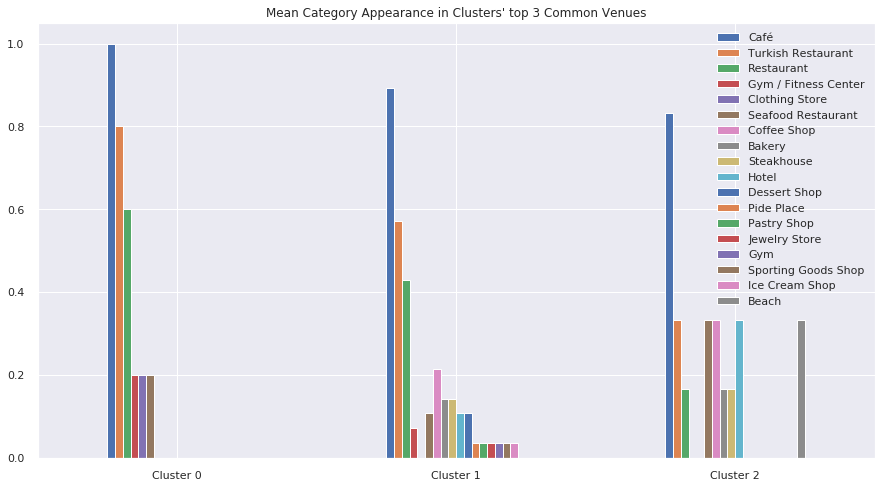

In [302]:
ax = pd.concat([clr0, clr1, clr2], sort=False, axis=1).transpose().plot(kind='bar', figsize=(15, 8))
plt.title("Mean Category Appearance in Clusters' top 3 Common Venues") 
plt.xticks(rotation=0)

### Visualizing Average Housing Sale Price for each cluser

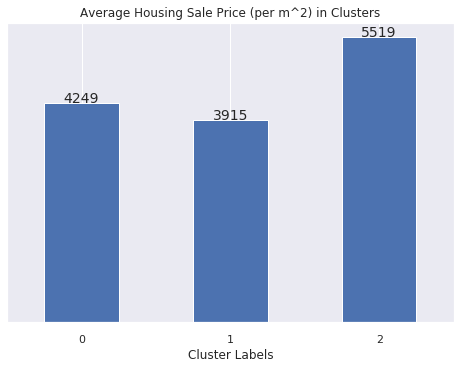

In [298]:
ax = istanbul_merged[['Cluster Labels', 'Sale Price']].groupby('Cluster Labels').mean().plot(kind='bar', yticks=[], legend=False)
plt.title("Average Housing Sale Price (per m^2) in Clusters") 
plt.xticks(rotation=0)
for i in ax.patches:
    ax.text(i.get_x()+0.13, i.get_height()+1, str(int(i.get_height())), fontsize=14)

### Visualizing Final Clustering Resuts on Istanbul Map

In [166]:
import matplotlib.cm as cm
import matplotlib.colors as colors

In [319]:
# create map
map_clusters = folium.Map(location=[ist_lat, ist_lng], zoom_start=9)
nl = '\n'
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, top in zip(istanbul_results['Latitude'], istanbul_results['Longitude'], istanbul_results['District'], istanbul_results['Cluster Labels'], istanbul_results['Top Venues']):
    label = folium.Popup(f'{str(poi)} District - Cluster {str(cluster)} - Top Venues: {top}', parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.6).add_to(map_clusters)
       
map_clusters